In [20]:
from numpy import reshape
import seaborn as sns
import pandas as pd  
import torch
from os import listdir, walk
from os.path import isfile, join
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import soundfile as sf
import numpy as np
from IPython.display import display, Audio
import librosa
import random
def ms2samples(time, rate):
    return int((time/1000)*rate)

def samples2ms(sample,rate):
    return int((sample/rate)*1000)
    
def graph_n_play(y,sr):
    fig, ax = plt.subplots()
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                                   sr=sr, ax=ax)
    ax.set(title='Linear-frequency power spectrogram')
    ax.label_outer()
    display(Audio(y,rate=sr))
    plt.show()
def linear_n_play(audio_path, sr=None):
    # y, sr = sf.read(audio_path)
    y, sr = librosa.load(audio_path, sr=sr)
    fig, ax = plt.subplots()
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                                   sr=sr, ax=ax)
    ax.set(title='Linear-frequency power spectrogram')
    ax.label_outer()
    display(Audio(y,rate=sr))
    plt.show()
def recursive_list_files(path, file_extension=".wav"):
    """Recursively lists all files in a directory and its subdirectories"""
    files = []
    for dirpath, dirnames, filenames in walk(path):
        for filename in filenames:
            if filename.endswith(file_extension):
                files.append(join(dirpath, filename))
    return files
from audio_augmentor import BackgroundNoiseAugmentor

In [2]:
SAMPLE_WAV = "/dataa/Dataset/ASVspoof/LA/ASVspoof2019_LA_train/flac/LA_T_5260333.flac"
CONFIG = {
        "aug_type": "background_noise",
        "output_path": "./",
        "out_format": "wav",
        "noise_path": "/dataa/Dataset/Noise/musan/music/",
        "min_SNR_dB": -5,
        "max_SNR_dB": 20
    }


noisy audio


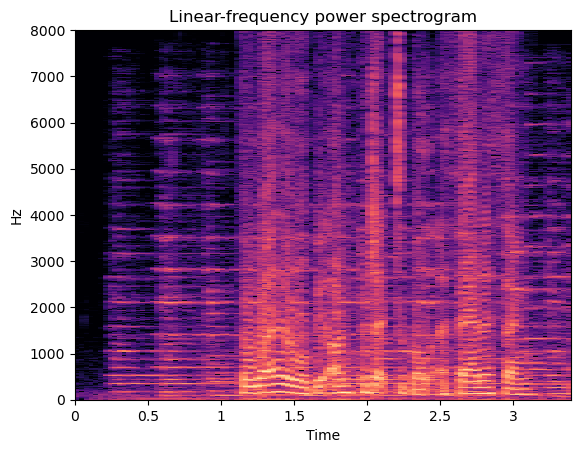

In [3]:
print("noisy audio")
linear_n_play("LA_T_5260333.wav")


In [4]:
# spleeter
!spleeter separate -o output/ LA_T_5260333.wav

INFO:spleeter:File output/LA_T_5260333/accompaniment.wav written succesfully
INFO:spleeter:File output/LA_T_5260333/vocals.wav written succesfully


vocals


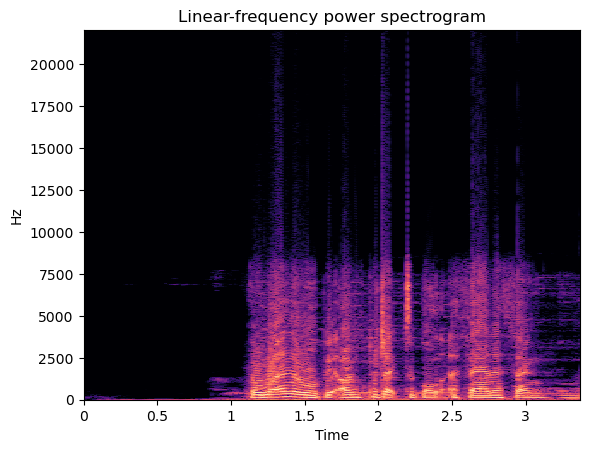

In [5]:
print("vocals")
linear_n_play("output/LA_T_5260333/vocals.wav")

In [17]:
# demucs
# Customize the following options!
model = "htdemucs"
extensions = ["mp3", "wav", "ogg", "flac"]  # we will look for all those file types.
# two_stems = None   # only separate one stems from the rest, for instance
two_stems = "vocals"

# Options for the output audio.
mp3 = False
mp3_rate = 320
float32 = True  # output as float 32 wavs, unsused if 'mp3' is True.
int24 = False    # output as int24 wavs, unused if 'mp3' is True.
# You cannot set both `float32 = True` and `int24 = True` !!

In [15]:
#@title Useful functions, don't forget to execute
import io
from pathlib import Path
import select
from shutil import rmtree
import subprocess as sp
import sys
from typing import Dict, Tuple, Optional, IO


def find_files(in_path):
    out = []
    for file in Path(in_path).iterdir():
        if file.suffix.lower().lstrip(".") in extensions:
            out.append(file)
    return out

def copy_process_streams(process: sp.Popen):
    def raw(stream: Optional[IO[bytes]]) -> IO[bytes]:
        assert stream is not None
        if isinstance(stream, io.BufferedIOBase):
            stream = stream.raw
        return stream

    p_stdout, p_stderr = raw(process.stdout), raw(process.stderr)
    stream_by_fd: Dict[int, Tuple[IO[bytes], io.StringIO, IO[str]]] = {
        p_stdout.fileno(): (p_stdout, sys.stdout),
        p_stderr.fileno(): (p_stderr, sys.stderr),
    }
    fds = list(stream_by_fd.keys())

    while fds:
        # `select` syscall will wait until one of the file descriptors has content.
        ready, _, _ = select.select(fds, [], [])
        for fd in ready:
            p_stream, std = stream_by_fd[fd]
            raw_buf = p_stream.read(2 ** 16)
            if not raw_buf:
                fds.remove(fd)
                continue
            buf = raw_buf.decode()
            std.write(buf)
            std.flush()

def separate(inp=None, outp=None):
    inp = inp
    outp = outp
    cmd = ["python3", "-m", "demucs.separate", "-o", str(outp), "-n", model]
    if mp3:
        cmd += ["--mp3", f"--mp3-bitrate={mp3_rate}"]
    if float32:
        cmd += ["--float32"]
    if int24:
        cmd += ["--int24"]
    if two_stems is not None:
        cmd += [f"--two-stems={two_stems}"]
    files = [str(f) for f in find_files(inp)]
    if not files:
        print(f"No valid audio files in {inp}")
        return
    print("Going to separate the files:")
    print('\n'.join(files))
    print("With command: ", " ".join(cmd))
    p = sp.Popen(cmd + files, stdout=sp.PIPE, stderr=sp.PIPE)
    copy_process_streams(p)
    p.wait()
    if p.returncode != 0:
        print("Command failed, something went wrong.")



In [18]:
separate("./", "output_demucs/")


Going to separate the files:
LA_T_5260333.wav
With command:  python3 -m demucs.separate -o output_demucs/ -n htdemucs --float32 --two-stems=vocals
Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in /dataa/phucdt/audio_preprocess/output_demucs/htdemucs
Separating track LA_T_5260333.wav


100%|██████████████████████████████████████████████████████████████████████████| 5.85/5.85 [00:04<00:00,  1.36seconds/s]


demucs separate vocals


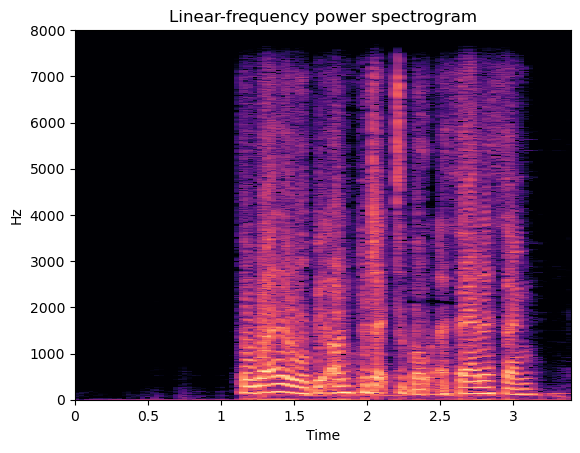

In [21]:
print("demucs separate vocals")
linear_n_play("output_demucs/htdemucs/LA_T_5260333/vocals.wav", sr=16000)